### TODO:
* Tensorize
* Organize transforms
* Organize weight initializations
* Base ResNet to identify what pets are in consideration
* Organize gradient settings
* Refactor model selection to create universal approach for adjusting final layer

# General Imports and Setup

In [1]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision.models as models
import torchmetrics
import pytorch_lightning as pl

# from skimage import io, transform
# from skimage import io
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

import os
import shutil
import logging
import yaml
from tqdm import tqdm
import math
from typing import Optional
from functools import partial
from datetime import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    
# ROOT_DIR = '/home/elandg/ml/Pawpularity'
ROOT = os.getcwd()
print(ROOT)
DATA_PATH = os.path.join(ROOT, "data/")
print(DATA_PATH)
data_path_partial = partial(os.path.join, DATA_PATH)

cuda:0
NVIDIA GeForce GTX 1050
/home/elandg/ml/Pawpularity
/home/elandg/ml/Pawpularity/data/


# Competition Download

Uncomment and run these code cells to load the dataset.

In [2]:
# # ! pip uninstall -y kaggle # run if error '429' when trying to download competition
# % cd /content/drive/MyDrive/'Colab Notebooks"/Pawpularity
# ! mkdir ~/.kaggle
# ! cp ../kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! pip install -q kaggle --upgrade
# ! kaggle -v
# ! kaggle competitions download -c petfinder-pawpularity-score -o
# ! ls

In [3]:
# ! kaggle competitions download -h

In [4]:
# ! unzip -q -o petfinder-pawpularity-score.zip

<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
        the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



# Create Dataset

In [5]:
# Read in config
with open(os.path.join(ROOT, "config/config.yaml")) as f:
    cf = yaml.safe_load(f)

num_bins = cf["data"]["num_bins"]

In [6]:
"""Generate CSV"""


def bin_csv(csv_path_callable: callable = data_path_partial,
            num_bins: int = 100,
            save_binned_csv: bool = False) -> pd.DataFrame:
    """
    Loads and bins base csv, which has labels of Pawpularity scores 1-100
    Avoid binning by passing num_bins = 100 or leaving it default
    """
    if num_bins and not (1 <= num_bins <= 100):
        logging.warning(
            f"num_bins should be between 1 and 100. Pawpularity ranges from 1-100 and is rescaled to 0-99"
        )

    df_raw = pd.read_csv(csv_path_callable("train.csv"))

    # Change labels to 0-99
    df_binned = df_raw.assign(Pawpularity=df_raw["Pawpularity"] - 1 //
                              (100 // num_bins))

    if save_binned_csv:
        df_binned.to_csv(csv_path_callable(f"train_{num_bins}_bins.csv"),
                         index=False)

    return df_binned


df = bin_csv(num_bins=num_bins, save_binned_csv=True)
# df = bin_csv(save_binned_csv=True)

# df_raw.head()
# print(df.head())
print(df.sort_values(by="Pawpularity", ascending=True).head())
# df_binned_10.head()
# df_binned_5.head()

                                    Id  Subject Focus  Eyes  Face  Near  \
8674  e0a1efdaf4fbed8659b6d23994ee346e              0     1     1     1   
2442  3ed899a8334a8e5c74f4a554f3ce6f08              0     1     1     1   
3232  53b536999aecd800cfda720f3ca363cb              0     1     1     1   
4235  6c159aede3df25fdbe781431aabcfc67              0     1     1     1   
9303  f0f8a92c1fe2e32bff35e7bf32400163              0     1     1     0   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
8674       0          0      0        0      1          1     0     0   
2442       0          0      0        0      0          0     0     0   
3232       0          0      0        0      0          0     0     0   
4235       0          0      0        0      0          0     0     0   
9303       0          0      1        0      0          0     0     0   

      Pawpularity  
8674            0  
2442            0  
3232            0  
4235            0  
9303      

In [7]:
class PawpularityDataset(Dataset):
    """Pawpularity dataset."""

    def __init__(self, df, img_dir, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing Pawpularity information
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        metadata = df.iloc[idx, 1:13].values.astype(np.uint8)

        img_path = os.path.join(self.img_dir, self.df.at[idx, "Id"] + ".jpg")
        image = read_image(img_path).to(torch.float32) / 255
        if self.transform:
            image = self.transform(image)

        # score = torch.tensor(self.df.at[idx, 'Pawpularity'] - 1).float()
        score = self.df.at[idx, "Pawpularity"]

        return {"image": image, "metadata": metadata, "score": score}

    def get_img_sizes(self, fresh_run=True, append_to_df=True):
        if fresh_run:
            self.df = self.df.drop(columns=["Shape"], errors="ignore")

        img_sizes = []
        if "Shape" not in self.df.columns:
            for i in tqdm(range(len(self))):
                img = self[i]["image"]
                img_sizes.append(list(img.shape))
            if append_to_df:
                self.df.loc[:, "Shape"] = img_sizes
        else:
            img_sizes = self.df["Shape"]
        return torch.tensor(img_sizes)


# Parameters for "Data Analysis"
images = data_path_partial("images")
img_size = [cf["data"]["augs"]["resize"]] * 2
dset = PawpularityDataset(df, images)
toy_dset = PawpularityDataset(df[:100], images)

# Data Analysis

In [8]:
# batch_size_da = cf["bs_da"]
# dataloader = DataLoader(dset, batch_size=batch_size_da, shuffle=False, num_workers=2)

0 99


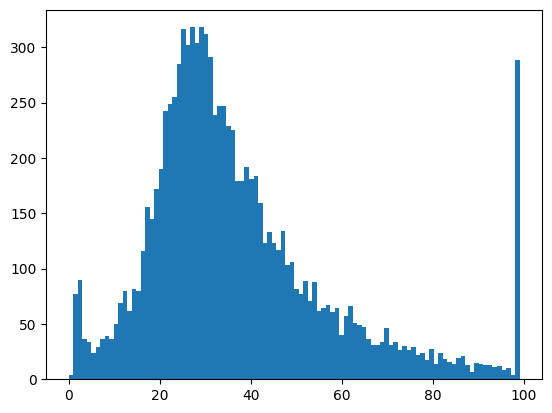

In [9]:
scores = dset.df["Pawpularity"]
_ = plt.hist(scores, bins=100)
print(min(scores), max(scores))

In [10]:
def plot_scatter_sizes(img_sizes):
    img_sizes = img_sizes
    plt.scatter(img_sizes[:, 2], img_sizes[:, 1], color="blue", alpha=.1)
    plt.show()


def plot_scatter_ratios(img_sizes):
    # print(img_sizes[:,0] / img_sizes[:,1])
    # dist of aspect ratios
    plt.scatter(range(len(img_sizes)),
                img_sizes[:, 2] / img_sizes[:, 1],
                alpha=.1)
    plt.show()


def largest_n_img_sizes(img_sizes, top_n=5):
    sorted, indices = (img_sizes[:, 1] * img_sizes[:, 2]).sort(descending=True)
    print(img_sizes[indices[0:top_n]])


def run_long_analysis(dset, fresh_run=True):
    img_sizes = dset.get_img_sizes(fresh_run=fresh_run)

    plot_scatter_sizes(img_sizes)
    plot_scatter_ratios(img_sizes)
    largest_n_img_sizes(img_sizes)


# run_long_analysis(dset, fresh_run=True)

In [11]:
# Run to compute optimal number of workers for system
from time import time
import multiprocessing as mp
import os


def find_opt_num_workers(dset, batch_size):
    # Determine max number of CPU cores
    max_cores = os.cpu_count()
    opt_num_workers = 0
    min_time = float('inf')
    for num_workers in range(0, max_cores + 2, 2):
        start_time = time()
        dataloader = DataLoader(dset,
                                batch_size=batch_size,
                                num_workers=num_workers)

        for batch in dataloader:
            # Simulate training process (CPU or GPU)
            if torch.cuda.is_available():
                batch = batch["image"].cuda()  # Move to GPU if available
            # Simulate a simple operation
            _ = batch * 2

        end_time = time()
        timespan = end_time - start_time
        print(f"num_workers={num_workers}, time={timespan:.2f}s")
        if timespan < min_time:
            opt_num_workers = num_workers
            min_time = timespan
    return opt_num_workers


def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for batch in dataloader:
        data = batch["image"]
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std


transform = transforms.Compose([transforms.Resize(img_size)])
dset = PawpularityDataset(df, images, transform=transform)

# opt_num_workers = find_opt_num_workers(dset, cf["bs"])
opt_num_workers = 8
print(f'Optimum num workers: {opt_num_workers}')

dataloader = torch.utils.data.DataLoader(dset,
                                         batch_size=cf["loader"]["bs"],
                                         shuffle=True,
                                         num_workers=opt_num_workers)
# mean, std = get_mean_and_std(dataloader)
# mean, std = torch.tensor([0.5188, 0.4840, 0.4462]), torch.tensor([0.2652, 0.2608, 0.2629])
mean, std = torch.tensor([0.485, 0.456,
                          0.406]), torch.tensor([0.229, 0.224,
                                                 0.225])  # ImageNet
print(f'mean: {mean}, std: {std}')

transform = transforms.Compose(
    [transforms.Resize(img_size),
     transforms.Normalize(mean, std)])
dset = PawpularityDataset(df, images, transform=transform)

Optimum num workers: 8
mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])


# Design Model

In [12]:
from torchvision.models import (resnet50, ResNet50_Weights, efficientnet_v2_l,
                                EfficientNet_V2_L_Weights, squeezenet1_1,
                                SqueezeNet1_1_Weights, mobilenet_v2,
                                MobileNet_V2_Weights, vit_b_16,
                                ViT_B_16_Weights)


# If not pretrained, initialize weights to small random values ("speeds up training")
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.uniform_(m.weight.data)
        # nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data)
        # nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


# model requires grad by default
# if we dont have weights aka FE is false
#     all layers require grad
# else we do have weights aka FE is true
#     all layers except last dont require grad


# Finetuning is taking a pretrained model and training more
# Feature extracting is using the pretrained model to extract features and only training final layers to make inference from extracted features
# Only training final layer if feature_extracting=True
def set_parameter_requires_grad(model, freeze_backbone):
    if freeze_backbone:
        # print(model.parameters())
        for param in model.parameters():
            param.requires_grad = False


class MetaNet(nn.Module):

    def __init__(self, backbone, bb_output_size, num_classes):
        super(MetaNet, self).__init__()
        self.backbone = backbone
        self.fc1 = nn.Linear(bb_output_size + 12,
                             64)  # 12 values from metadata
        self.fc2 = nn.Linear(64, num_classes)

        modules = [
            self.fc1, self.fc2
        ]  #TODO: find way to look through only layers added by this module
        for module in modules:
            weights_init(module)

    def forward(self, image, data):
        x1 = F.relu(self.backbone(image))
        x2 = data

        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def update_final_layer(model, num_classes):
    name = model.__class__.__name__
    if name == "ResNet":
        in_features = model.fc.in_features
        module = nn.Linear(in_features, num_classes)
        module.apply(weights_init)
        model.fc = module
    elif name == "SqueezeNet":
        in_channels = model.classifier[1].in_channels
        module = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels,
                      num_classes,
                      kernel_size=(1, 1),
                      stride=(1, 1)), nn.AdaptiveAvgPool2d(output_size=(1, 1)))
        module.apply(weights_init)
        model.classifier = module
    elif name == "EfficientNet":
        in_features = model.classifier[1].in_features
        module = nn.Linear(in_features, num_classes)
        module.apply(weights_init)
        model.classifier[1] = module
    elif name == "MobileNetV2":
        in_features = model.classifier[1].in_features
        module = nn.Linear(in_features, num_classes)
        module.apply(weights_init)
        model.classifier[1] = module
    elif name == "VisionTransformer":
        in_features = model.heads.head.in_features
        module = nn.Linear(in_features, num_classes)
        module.apply(weights_init)
        model.heads.head = module
    else:
        print(f"Invalid model name: {name}, exiting...")

    return model


def initialize_model(model_func,
                     num_classes,
                     use_metadata=False,
                     freeze_backbone=False,
                     pretrained_weights=None):
    assert (
        freeze_backbone != True or pretrained_weights is not None
    ), "You should not freeze the backbone unless you are using pretrained weights"

    model = model_func(weights=pretrained_weights)
    if pretrained_weights is None:
        model.apply(weights_init)
    set_parameter_requires_grad(model, freeze_backbone)
    if use_metadata:
        model = MetaNet(
            model, 1000, num_classes
        )  # remove hardcoding --> get layer to remove if not metadata and check out_channels
    else:
        model = update_final_layer(model, num_classes)

    return model


model_dicts = {
    "resnet": {
        "model": models.resnet50,
        "weights": ResNet50_Weights.IMAGENET1K_V2
    },
    "efficient": {
        "model": models.efficientnet_v2_l,
        "weights": EfficientNet_V2_L_Weights.IMAGENET1K_V1
    },
    "squeezenet": {
        "model": models.squeezenet1_1,
        "weights": SqueezeNet1_1_Weights.IMAGENET1K_V1
    },
    "convnext": {
        "model": models.mobilenet_v2,
        "weights": MobileNet_V2_Weights.IMAGENET1K_V2
    },
    "vit": {
        "model": models.vit_b_16,
        "weights": ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
    }
}
# for _, value in model_dicts.items():
#     model_dict = value
#     model, transform = initialize_model(
#         model_dict["model"],
#         1,
#         use_metadata=False,
#         freeze_backbone=True,
#         # pretrained_weights=None
#         pretrained_weights=model_dict["weights"]
#     )

model_dict = model_dicts[cf["model"]["name"]]
num_classes = 1
if cf["model"]["pretrained_weights"]:
    pretrained_weights = model_dict["weights"]
    transform = pretrained_weights.transforms()
    img_size = transform.resize_size
else:
    pretrained_weights = None
    img_size = [cf["data"]["augs"]["resize"]]
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.Normalize(mean=mean, std=std)
    ])
use_metadata = cf["model"]["use_metadata"]
model = initialize_model(model_dict["model"],
                         num_classes,
                         use_metadata=False,
                         freeze_backbone=False,
                         pretrained_weights=pretrained_weights)
model.to(device);

In [13]:
# Print the model we just instantiated
with open("model.txt", "w") as f:
    print(model, file=f)

# calc new rgb mean and std with new image size?
# be able to have a shortcut button to run selected cell cluster that is always on the screen. similar to run above and cell/below
# Functionality handled by lambda in optimizer but good to sanity check
with open("weights.txt", "w") as f:
    f.write("Params to learn: \n")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            f.write(f"\t {name}\n")

# N must be > 1 if using batch norm layer
input_shape = ([1, 3] + img_size * 2)
input_imgs = torch.zeros(input_shape)
if use_metadata:
    input_metadata = torch.zeros((2, 12))
    output = model(input_imgs.to(device), input_metadata.to(device))
else:
    output = model(input_imgs.to(device))

print(output.shape)
summary(model, input_shape)
# print(output.T[0].float())
# print(output.argmax(1).float())

torch.Size([1, 1])


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 116, 116]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 116, 116]         128
├─ReLU: 1-3                              [1, 64, 116, 116]         --
├─MaxPool2d: 1-4                         [1, 64, 58, 58]           --
├─Sequential: 1-5                        [1, 256, 58, 58]          --
│    └─Bottleneck: 2-1                   [1, 256, 58, 58]          --
│    │    └─Conv2d: 3-1                  [1, 64, 58, 58]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 58, 58]           128
│    │    └─ReLU: 3-3                    [1, 64, 58, 58]           --
│    │    └─Conv2d: 3-4                  [1, 64, 58, 58]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 58, 58]           128
│    │    └─ReLU: 3-6                    [1, 64, 58, 58]           --
│ 

In [14]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r - a  # free inside reserved
print(t)
print(r)
print(a)
print(f)
torch.cuda.mem_get_info()

4294836224
241172480
198449664
42722816


(3274702848, 4294836224)

# Prepare Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


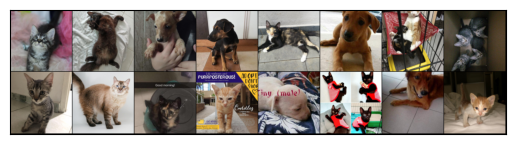

tensor([[30, 24, 44, 62, 19, 76, 34, 11],
        [15, 67, 31, 22,  3, 30, 42, 35]])


In [15]:
dataset = PawpularityDataset(df, images, transform=transform)

# 9912 samples total
trainset, valset, testset = torch.utils.data.random_split(
    dataset, [7000, 2000, 912])

viz_loader = torch.utils.data.DataLoader(testset,
                                         batch_size=16,
                                         shuffle=False,
                                         num_workers=opt_num_workers)


class UnNormalize(torchvision.transforms.Normalize):

    def __init__(self, mean, std, *args, **kwargs):
        new_mean = [-m / s for m, s in zip(mean, std)]
        new_std = [1 / s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)


# function to show an image - seems like images are not restored properly
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()


batch = next(iter(viz_loader))

# show images
transform = transforms.Compose([
    UnNormalize(mean=mean, std=std),
    transforms.Resize(img_size),
])
nrow = 8
grid = torchvision.utils.make_grid(transform(batch['image']), nrow=nrow)
imshow(grid)
grid_shape = (int(math.ceil(len(batch["image"]) / nrow)), nrow)
print(batch['score'].reshape(grid_shape))

# Train Model

In [18]:
model_dicts = {
    "resnet": {
        "model": models.resnet50,
        "weights": ResNet50_Weights.IMAGENET1K_V2
    },
    "efficient": {
        "model": models.efficientnet_v2_l,
        "weights": EfficientNet_V2_L_Weights.IMAGENET1K_V1
    },
    "squeezenet": {
        "model": models.squeezenet1_1,
        "weights": SqueezeNet1_1_Weights.IMAGENET1K_V1
    },
    "convnext": {
        "model": models.mobilenet_v2,
        "weights": MobileNet_V2_Weights.IMAGENET1K_V2
    },
    "vit": {
        "model": models.vit_b_16,
        "weights": ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
    }
}


class RMSELoss(nn.Module):

    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, pred, target):
        loss = torch.sqrt(self.mse(pred, target) + self.eps)
        return loss


metrics = {
    "mse": torchmetrics.MeanSquaredError(),
    "rmse": torchmetrics.MeanSquaredError(squared=False)
}


class PawpularitySystem(pl.LightningModule):

    def __init__(self, cf):
        super().__init__()
        self.cf = cf
        model_dict = model_dicts[cf["model"]["name"]]
        num_classes = 1
        if cf["model"]["pretrained_weights"]:
            pretrained_weights = model_dict["weights"]
            transform = pretrained_weights.transforms()
            img_size = transform.resize_size
        else:
            pretrained_weights = None
            img_size = [cf["data"]["augs"]["resize"]]
            transform = transforms.Compose([
                transforms.Resize(img_size),
                transforms.Normalize(mean=mean, std=std)
            ])
        self.use_metadata = cf["model"]["use_metadata"]
        if self.use_metadata:
            self.forward_func = self.forward_metadata_
        else:
            self.forward_func_ = self.forward_no_metadata_
        self.model = initialize_model(
            model_dict["model"],
            num_classes,
            use_metadata=cf["model"]["use_metadata"],
            freeze_backbone=cf["model"]["freeze_backbone"],
            pretrained_weights=pretrained_weights)

        self.criterion = metrics[cf["model"]["loss"]]
        self.val_loss = torchmetrics.MeanMetric()
        # self.metrics = {}
        self.metrics = torch.nn.ModuleDict(
            {k: metrics[k]
             for k in cf["model"]["metrics"]})

    def forward_no_metadata_(self, image, metadata):
        return self.model(image)

    def forward_metadata_(self, image, metadata):
        return self.model(image, metadata)

    def forward(self, image, metadata):
        return self.forward_func_(image, metadata)

    def training_step(self, batch, batch_idx):
        image, metadata, score = batch["image"], batch["metadata"], batch[
            "score"].unsqueeze(1)
        output = self(image, metadata)
        loss = self.criterion(output, score)

        bs = image.shape[0]
        self.log("train_loss", loss, on_step=True, batch_size=bs)

        return loss

    @torch.inference_mode()
    def validation_step(self, batch, batch_idx):
        image, metadata, score = batch["image"], batch["metadata"], batch[
            "score"].unsqueeze(1)
        output = self(image, metadata)
        loss = self.criterion(output, score)

        self.val_loss.update(loss)

        for metric in self.metrics.keys():
            self.metrics[metric].update(output, score)

    @torch.inference_mode()
    def on_validation_epoch_end(self):
        self.log("val_loss", self.val_loss.compute(), on_epoch=True)
        self.val_loss.reset()

        # compute metrics
        for metric in self.metrics.keys():
            self.log(f"val_{metric}",
                     self.metrics[metric].compute(),
                     on_epoch=True)

            # reset metrics
            self.metrics[metric].reset()

    @torch.inference_mode()
    def predict_step(self, batch, batch_idx):
        image, metadata, score = batch["image"], batch["metadata"], batch[
            "score"].unsqueeze(1)
        output = self(image, metadata)
        return output, score

    def configure_optimizers(self):
        # Passing frozen layers into optimizer should produce an error
        # "requires_grad has to be false AND the parameter cannot be given to the optimizer" -https://www.reddit.com/r/MLQuestions/comments/t3ipan/pytorchlightning_trainerfit_method_is_unfreezing/
        # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.8, dampening=0, weight_decay=0.00005)
        return optim.Adam(filter(lambda p: p.requires_grad,
                                 model.parameters()),
                          lr=self.cf["model"]["lr"])


with open(os.path.join(ROOT, "config/config.yaml")) as f:
    cf = yaml.safe_load(f)

lm = PawpularitySystem(cf)
exp_root = os.path.join(ROOT, "exp/", cf["exp_name"],
                        datetime.now().strftime("%Y%m%d-%H%M%S"))

logger = [
    pl.loggers.TensorBoardLogger(save_dir=exp_root, name="tb"),
    pl.loggers.CSVLogger(save_dir=exp_root, name="csv"),
]

# config callbacks
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step",
                                              log_momentum=False)

save_ckpts = pl.callbacks.ModelCheckpoint(
    every_n_epochs=cf["train"]["save_every_n_epochs"],
    filename='{epoch}-{val_loss:.2f}')

trainer = pl.Trainer(enable_progress_bar=True,
                     max_epochs=cf["train"]["num_epochs"],
                     callbacks=[lr_monitor, save_ckpts],
                     default_root_dir=exp_root,
                     logger=logger,
                     gradient_clip_val=cf["train"]["grad_clip_val"])

batch_size = cf["loader"]["bs"]
num_workers = cf["loader"]["num_workers"]

tr_loader = torch.utils.data.DataLoader(trainset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(valset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=num_workers)

te_loader = torch.utils.data.DataLoader(testset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=num_workers)

trainer.fit(lm, train_dataloaders=tr_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /home/elandg/ml/Pawpularity/exp/basic_resnet/20240801-033958/tb
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 23.5 M | train
1 | criterion | MeanSquaredError | 0      | train
2 | val_loss  | MeanMetric       | 0      | train
3 | metrics   | ModuleDict       | 0      | train
-------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 219/219 [04:27<00:00,  0.82it/s, v_num=0]       

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 219/219 [04:28<00:00,  0.82it/s, v_num=0]


In [ ]:
# from sklearn.metrics import mean_absolute_error
mean_absolute_error = nn.L1Loss()


# TODO: if path exists, print the stats to a text file all at once at the end
def log_training(epoch, stats, metric_labels, path=None):
    """Print the train, validation, test accuracy/loss/auroc.

    Each epoch in `stats` should have order
        [val_acc, val_loss, val_auc, train_acc, ...]
    Test accuracy is optional and will only be logged if stats is length 9.
    """
    splits = ["Val", "Train", "Test"]
    print(f'Epoch {epoch}')
    for j, split in enumerate(splits):
        for i, m in enumerate(metric_labels):
            idx = len(metric_labels) * j + i
            if idx >= len(stats[-1]):
                continue
            print(f'\t{split} {m}: {round(stats[-1][idx], 4)}')
    # include_train = len(stats[-1]) / 3 == 3
    # splits = ["Validation", "Train", "Test"]
    # metrics = ["Accuracy", "Loss", "MAE"]
    # if path is not None:
    #     with open(path, 'a') as f:
    #         print("Epoch {}".format(epoch), file=f)
    #         for j, split in enumerate(splits):
    #             for i, metric in enumerate(metrics):
    #                 idx = len(metrics) * j + i
    #                 if idx >= len(stats[-1]):
    #                     continue
    #                 print(f"\t{split} {metric}:{round(stats[-1][idx],4)}", file=f)
    # else:
    #     print("Epoch {}".format(epoch))
    #     for j, split in enumerate(splits):
    #         for i, metric in enumerate(metrics):
    #             idx = len(metrics) * j + i
    #             if idx >= len(stats[-1]):
    #                 continue
    #             print(f"\t{split} {metric}:{round(stats[-1][idx],4)}")


def print_plots(epoch, stats, metric_labels, name="CNN Training", path=None):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(name)
    # axes[0].set_xlabel("Epoch")
    # axes[0].set_ylabel("Accuracy")
    # axes[1].set_xlabel("Epoch")
    # axes[1].set_ylabel("Loss")
    # axes[2].set_xlabel("Epoch")
    # axes[2].set_ylabel("AUROC")

    splits = ["Validation", "Train", "Test"]
    colors = ["r", "b", "g"]
    for i, metric in enumerate(metric_labels):
        for j, split in enumerate(splits):
            idx = len(metric_labels) * j + i
            if idx >= len(stats[-1]):
                continue
            # __import__('pdb').set_trace()
            axes[i].plot(
                range(epoch - len(stats) + 1, epoch + 1),
                [stat[idx] for stat in stats],
                linestyle="--",
                marker="o",
                color=colors[j],
            )
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_labels[i])
        axes[i].legend(splits[:int(len(stats[-1]) / len(metric_labels))])
    if path:
        plt.savefig(path)
    plt.pause(0.00001)


def predictions(model_name, loss_criterion, output):
    # print(logits.size())
    if loss_criterion['name'] == 'CE':
        if 'inception' == model_name:
            pred = output.logits.argmax(axis=1).float()
        else:
            pred = output.argmax(axis=1).float()
    else:
        if 'inception' == model_name:
            pred = output.logits.T[0].float()
        else:
            pred = output.T[0].float()

    return pred


def train_epoch(data_loader, model, use_metadata, loss_criterion, optimizer):
    for i, sample in enumerate(data_loader, 0):
        # inputs, labels = data
        inputs = sample['image'].to(device)
        labels = sample['score'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        if use_metadata:
            metadata = sample['metadata'].to(device)
            output = model(inputs, metadata)
        else:
            output = model(inputs)
        loss = loss_criterion['criterion'](output, labels)
        loss.backward()
        optimizer.step()


def evaluate_epoch(tr_loader,
                   val_loader,
                   te_loader,
                   model,
                   use_metadata,
                   epoch,
                   metric_labels,
                   loss_criterion,
                   criterions=[],
                   stats=[],
                   include_test=False,
                   path=None):

    def _get_metrics(loader):
        correct, total = 0, 0
        # batch_size defined during data loader creation, TODO: clean up
        running_loss = []
        for sample in loader:
            with torch.no_grad():
                inputs = sample['image'].to(device)
                labels = sample['score']

                if use_metadata:
                    metadata = sample['metadata'].to(device)
                    output = model(inputs, metadata)
                else:
                    output = model(inputs)
                predicted = predictions(model.name, loss_criterion,
                                        output).cpu()

                total += labels.size(0)
                # labels = labels.to(device)
                # correct += (torch.abs(predicted - labels) < 5).sum().item()
                if loss_criterion['name'] == 'CE':
                    correct += (predicted == labels).sum().item()
                    # print(f'predicted: {predicted}, labels: {labels}')
                else:
                    correct += (
                        torch.div(predicted, 10, rounding_mode='floor') -
                        torch.div(labels, 10,
                                  rounding_mode='floor')).sum().item()
                # print(predicted, labels)
                # print(loss_criterion)
                # print(loss_criterion(predicted, labels))
                running_loss.append(loss_criterion['criterion'](
                    output, labels.to(device)).cpu())
        loss = np.mean(running_loss)
        # print(loss)
        acc = correct / total
        # mae = mean_absolute_error(predicted, labels.to(device)).item()
        return [acc, loss]

    train_stats = _get_metrics(tr_loader)
    # print(f'Train Acc: {train_acc}, Loss: {train_loss}, AUC: {train_auc}')
    val_stats = _get_metrics(val_loader)
    # print(f'Val Acc: {val_acc}, Loss: {val_loss}, AUC: {val_auc}')

    # stats_at_epoch = [
    #     val_acc,
    #     val_loss,
    #     val_auc,
    #     train_acc,
    #     train_loss,
    #     train_auc,
    # ]
    stats_at_epoch = []
    stats_at_epoch.extend(val_stats)
    stats_at_epoch.extend(train_stats)

    if include_test:
        stats_at_epoch.extend(_get_metrics(te_loader))

    stats.append(stats_at_epoch)
    # print(stats)
    log_training(epoch, stats, metric_labels, path)

    return stats


In [ ]:
save_name = net.name + '_1'
MODEL_PATH = os.path.join(ROOT, save_name + '.pt')
MODEL_STATS_PATH = os.path.join(ROOT, save_name + '.txt')
open(MODEL_STATS_PATH, 'w').close()
MODEL_GRAPHS_PATH = os.path.join(ROOT, save_name + '.jpg')

print(f'Training for {save_name}')

epoch = 0
max_epochs = 150
patience = 5
curr_patience_count = 0
metric_labels = ['ACC'] + [criterion['name'] for criterion in criterions]
loss_criterion = criterions[0]
# total[train, val, test[metric_labels[vals each epoch]]] potential reordering for stats
stats = []
include_test = False
stats = evaluate_epoch(tr_loader,
                       val_loader,
                       te_loader,
                       net,
                       use_metadata,
                       epoch,
                       metric_labels,
                       loss_criterion,
                       criterions=criterions,
                       stats=stats,
                       include_test=include_test,
                       path=MODEL_STATS_PATH)
epoch += 1
global_min_loss = stats[0][1]  # starting val loss

# for epoch in range(num_epochs):
while epoch < max_epochs and curr_patience_count < patience:
    train_epoch(tr_loader, net, use_metadata, loss_criterion, optimizer)

    stats = evaluate_epoch(tr_loader,
                           val_loader,
                           te_loader,
                           net,
                           use_metadata,
                           epoch,
                           metric_labels,
                           loss_criterion,
                           criterions=criterions,
                           stats=stats,
                           include_test=include_test,
                           path=MODEL_STATS_PATH)

    # print(stats)

    if stats[-1][1] < global_min_loss:
        curr_patience_count = 0
        global_min_loss = stats[-1][1]
        torch.save(net.state_dict(), MODEL_PATH)
    else:
        curr_patience_count += 1

    epoch += 1

print('Finished Training')
print_plots(epoch, stats, path=MODEL_GRAPHS_PATH)
#E Tutorial had 54% accuracyfnet
#E A good loss is below .5 but varies depending on application and dataset

NameError: name 'net' is not defined

# Test Model

In [ ]:
dataiter = iter(te_loader)
sample = dataiter.next()
images, metadata, labels = sample['image'], sample['metadata'], sample['score']

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',
      ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [ ]:
net.load_state_dict(torch.load('model1.pt'))
print(net.name)

In [ ]:
# run if runtime disconnects
# net = model_ft
net.load_state_dict(torch.load('model2.pt'))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
device = 'cpu'
net.to(device)
outputs = net(images.to(device), metadata.to(device))
print(outputs.cpu())

In [ ]:
# _, predicted = torch.max(outputs, 1)
# predicted = (np.round(outputs.logits.T[0].float().detach().numpy())).astype(int)
# predicted = (np.round(outputs.T[0].float().detach().numpy())).astype(int)
predicted = predictions(net.name, outputs).int().cpu().numpy()
# print(predicted)
# print(outputs)

print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(batch_size)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in te_loader:
        images, labels = sample["image"], sample["score"]
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        # _, preds = torch.max(outputs.data, 1)
        # preds = (np.round(outputs.logits.T[0].float().detach().numpy())).astype(int)
        preds = outputs.T[0].float()
        total += labels.size(0)
        # print(preds == labels)
        correct += (torch.abs(preds - labels) < 5).sum().item()

print("Accuracy of the network on the 1000 test images: %d %%" %
      (100 * correct / total))

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in te_loader:
        images, labels = data
        outputs = net(images)
        _, preds = outputs.logits.T[0].float()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

sum = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))